# W266 Project

### Adam Sayre & Erin Werner

Social media has provided the public with a platform for personal expression. This new outlet has given businesses the ability to assess the opinion of the consumer. By automatically detecting the overall feeling behind social media discourse, businesses can make more accurate decisions.

The purpose of this project is to determine the sentiment of tweets, beyond just learning the binary attitude. We want to attempt to detect the actual emotion from the text. This is important because it will provide an even better understanding of what the user is trying to communicate. 

## Exploratory Data Analysis

We will start by examining our dataset. Our data consists of tweets from an emotion dataset from Kaggle (2020), which have been labeled with their corresponding emotion: happy, angry, or disappointed. We chose this data because it includes a cleaned dataset (stripped of retweets, user-tags, and emojis) as well as the uncleaned tweets. 

In [1]:
import numpy as np
import csv
import pandas as pd 
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import importlib
import emoji
import tensorflow as tf
import nltk
import re
from nltk.corpus import brown
nltk.download('stopwords')
from nltk.corpus import stopwords
assert(nltk.download("treebank"))
from nltk.corpus import europarl_raw
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from collections import Counter

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/erinwerner/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package treebank to
[nltk_data]     /Users/erinwerner/nltk_data...
[nltk_data]   Package treebank is already up-to-date!


In [2]:
data = pd.read_csv("~/Downloads/dataset(clean).csv") 
data.head()

,Emotion,Content,Original Content
0,disappointed,oh fuck did i wrote fil grinningfacewithsweat ...,b'RT @Davbingodav: @mcrackins Oh fuck.... did ...
1,disappointed,i feel nor am i shamed by it,i feel nor am i shamed by it
2,disappointed,i had been feeling a little bit defeated by th...,i had been feeling a little bit defeated by th...
3,happy,imagine if that reaction guy that called jj kf...,"b""@KSIOlajidebt imagine if that reaction guy t..."
4,disappointed,i wouldnt feel burdened so that i would live m...,i wouldnt feel burdened so that i would live m...


In [3]:
len(data)

916575

In [4]:
data.Emotion.unique()

array(['disappointed', 'happy', 'angry'], dtype=object)

In [5]:
summary_data = data.groupby('Emotion').count()
summary_data[['Content','Original Content']]

,Content,Original Content
Emotion,,
angry,300990,300990
disappointed,313714,313714
happy,301871,301871


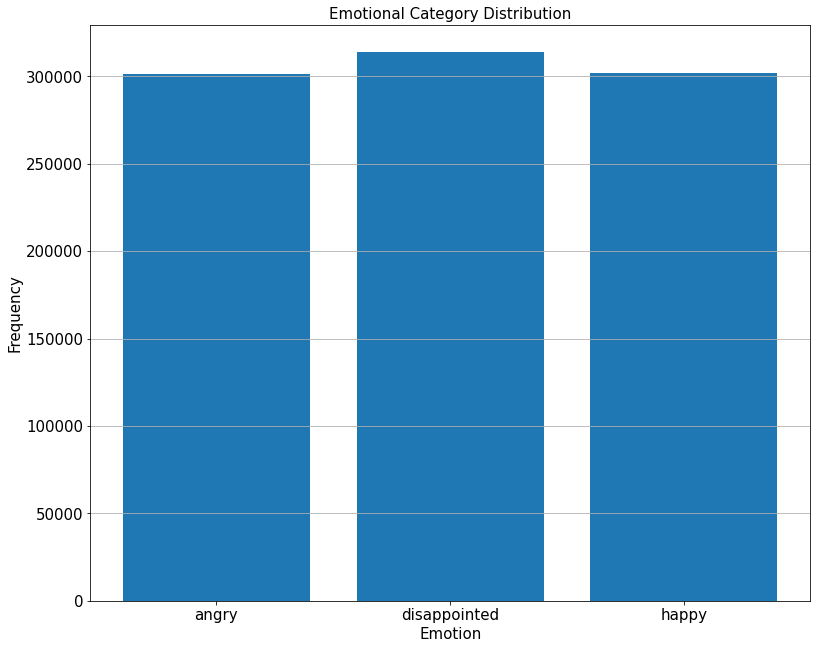

In [6]:
fig = plt.figure(figsize=[10,8])
ax = fig.add_axes([0,0,1,1])
emotions = ['angry', 'disappointed', 'happy']
ax.bar(emotions,summary_data.Content)

plt.grid(axis='y')
plt.xlabel('Emotion',fontsize=15)
plt.ylabel('Frequency',fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.title('Emotional Category Distribution',fontsize=15)

plt.show()

From the histogram, we can see that each of the classes are relatively balanced, which means that they are each represented equally in the dataset. This is ideal for building our model as there won't be any significant bias towards one group or another.

We also want to know some of the frequent terms that appear in each of the tweets. These terms could be indicative of the sentiment behind the tweet, meaning that those words would be influential in our model.

In order to get a general idea of what some of these phrases are, we will build a word cloud that displays the most common words from the overall data set. Then, we will generate an individual words cloud for each emotional class. This will provide a more nuanced understanding of terms that expressed the given emotion.

In [7]:
text = ""
for i in data['Content']:
    text +=  ' ' + i

#### General Word Cloud

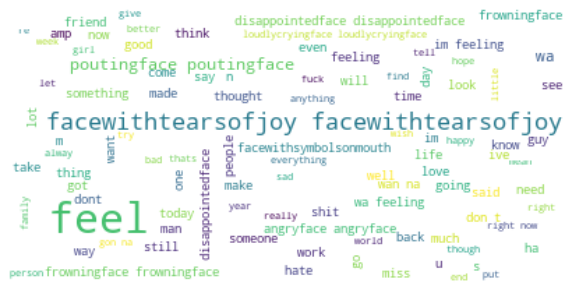

In [8]:
wordcloud_gen = WordCloud(background_color="white",max_words=100).generate(text)
plt.figure(figsize=[10,8])
plt.imshow(wordcloud_gen, interpolation='bilinear',)
plt.axis("off")
plt.show()

From this general word cloud, we can see that pairs of emojis are a very common way for users to express themselves in tweets. 

Now, we can take a look at the word cloud for each of the classes.

In [9]:
text_angry = ""
text_disappointed = ""
text_happy = ""

for i in range(0,len(data)):
    emotion = data['Emotion'][i]
    content = data['Content'][i]
    
    if emotion == "angry":
        text_angry += ' ' + content
    elif emotion == "disappointed":
        text_disappointed += ' ' + content
    else:
        text_happy += ' ' + content

#### Angry Word Cloud

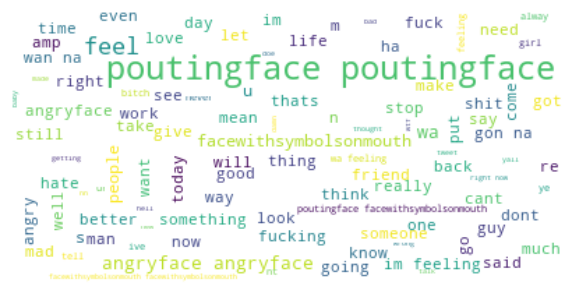

In [10]:
wordcloud_angry = WordCloud(background_color="white",max_words=100).generate(text_angry)
plt.figure(figsize=[10,8])
plt.imshow(wordcloud_angry, interpolation='bilinear',)
plt.axis("off")
plt.show()

In the angry word cloud, upset or angry emojis are very common. There are appears to be some profanity and negatively connotated words.

#### Disappointed Word Cloud

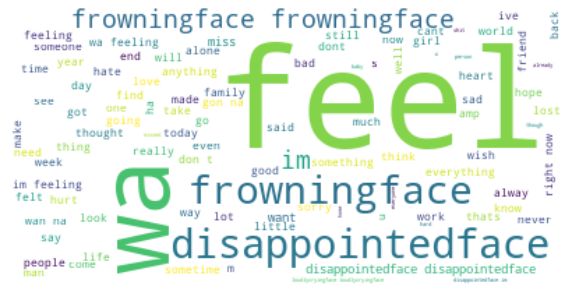

In [11]:
wordcloud_dis = WordCloud(background_color="white",max_words=100).generate(text_disappointed)
plt.figure(figsize=[10,8])
plt.imshow(wordcloud_dis, interpolation='bilinear',)
plt.axis("off")
plt.show()

In the disappointed word cloud, the word 'feel' is extremely prominent. This means that it is very common in tweets that express disappointment. We can also see that disappointed or frowning emojis are also frequently used.

#### Happy Word Cloud

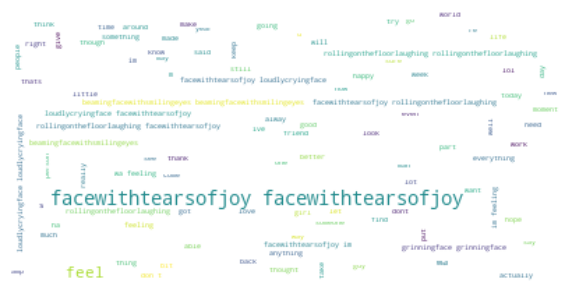

In [12]:
wordcloud_happy = WordCloud(background_color="white",max_words=100).generate(text_happy)
plt.figure(figsize=[10,8])
plt.imshow(wordcloud_happy, interpolation='bilinear',)
plt.axis("off")
plt.show()

In the happy word cloud, we can see that most of the terms are smaller of font and are more spread out. This means that there is a wide distribution of terms that make up tweets in the 'happy' classification. As a result, "happy" phrases may not be as influential in our model. Yet, we can still see that smiling and laughing emjois are gnerally more common.

As emojis are clearly a very expressive part of the text in tweets, we want to take a closer look into the emojis that are most frequently used. To start, we can take an overall look of how emojis are represented across different platforms.


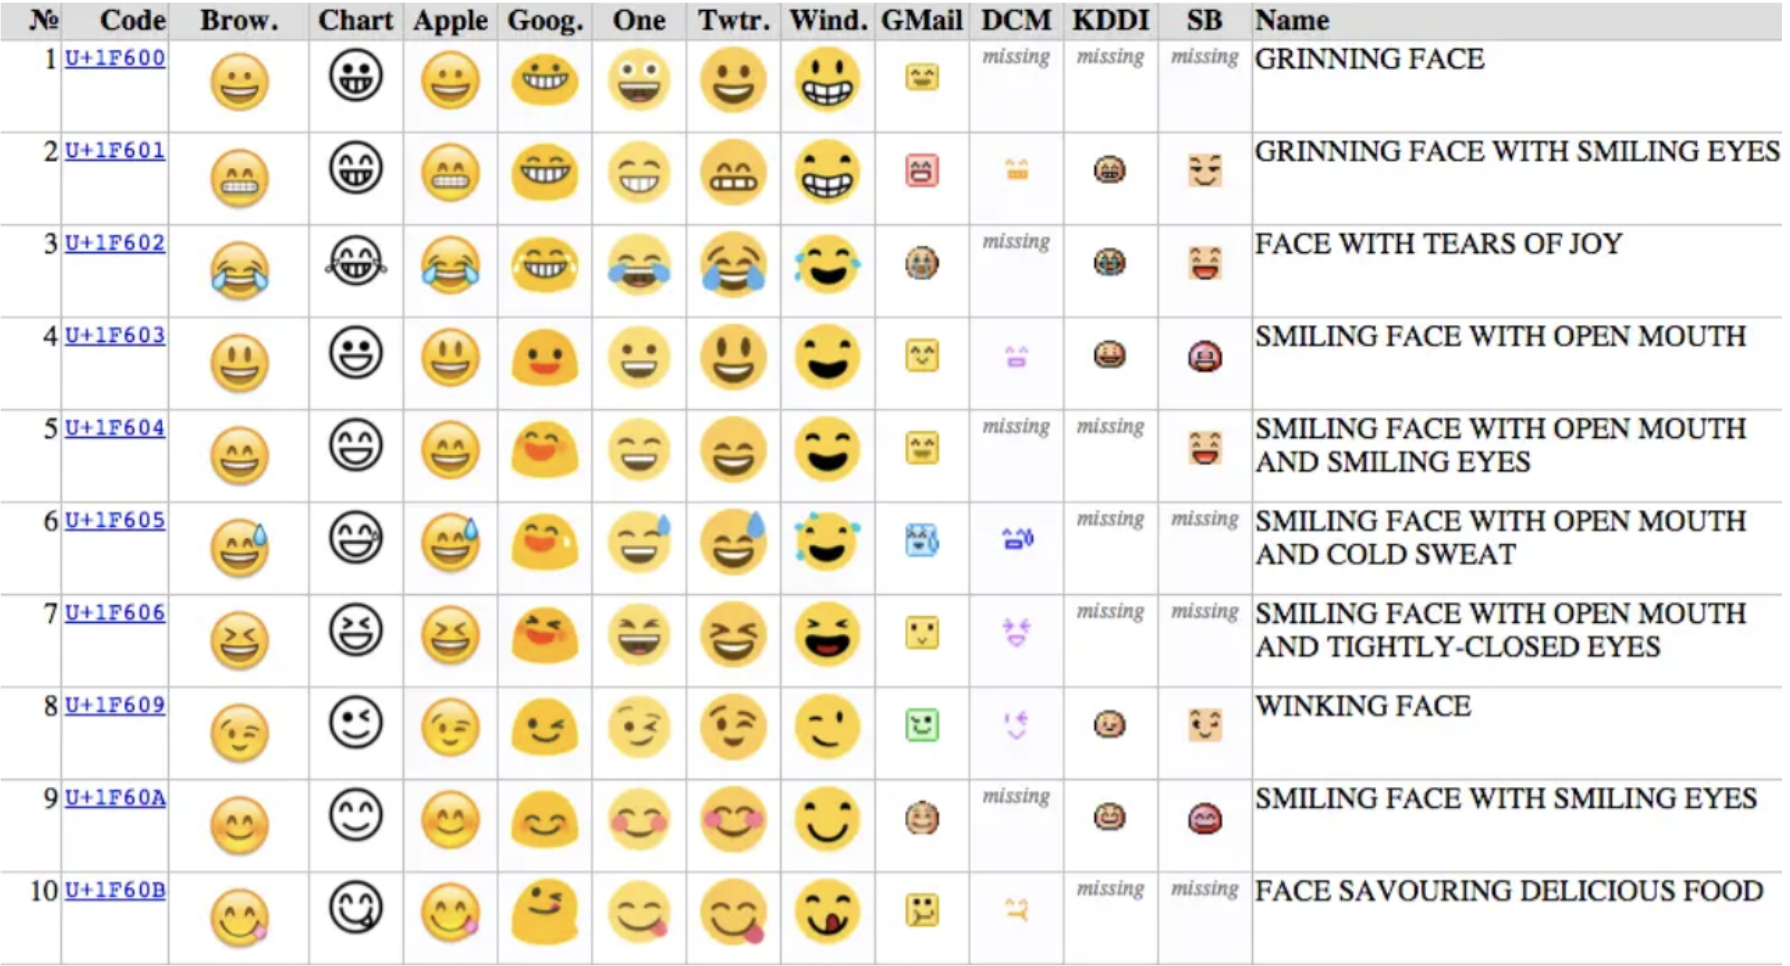

From the chart above, we can see that although there are different visual representations, each emoji has the same descriptions and generally expresses the same sentiment.

Now, we want to understand which emojis are the most common in our dataset.

In [13]:
my_emojis = []

for i in range(0,len(data)):
    text = data['Original Content'][i]
    text = text.replace('\\n',' ')
    text = text.replace('#',' ')
    text = text.replace('&',' ')
    text = text.replace('*',' ')
    text = text.replace('\\',' ')
    text = text.replace('@',' ')
    text = text.split()
    for i in text:
        if i.startswith(":") and i.endswith(":"):
            my_emojis.append(i)

In [14]:
individual_emojis = []

for i in my_emojis:
    text = i.replace(":", " ")
    text = text.split()
    for j in text:
        individual_emojis.append(j)

In [15]:
my_counts = Counter(individual_emojis).most_common(10)

labels = []
counts = []

for i in my_counts:
    labels.append(i[0])
    counts.append(i[1])

In [16]:
emoji_labels = []
for em in labels:
    my_string = ":" + em + ":"
    emoji_labels.append(my_string)

In [17]:
def autolabel(rects,emoji_labels):
    """Attach a text label above each bar in *rects*, displaying its height."""
    index = 0
    for rect in rects:
        height = rect.get_height()
        emoji_lab = emoji.emojize(emoji_labels[index])
        ax.annotate(#'{}'.format(emoji_lab),
                    emoji_lab,
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
        index += 1

/Users/erinwerner/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129315 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/erinwerner/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 129324 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/erinwerner/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129315 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/erinwerner/opt/anaconda3/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 129324 missing from current font.
  font.set_text(s, 0, flags=flags)


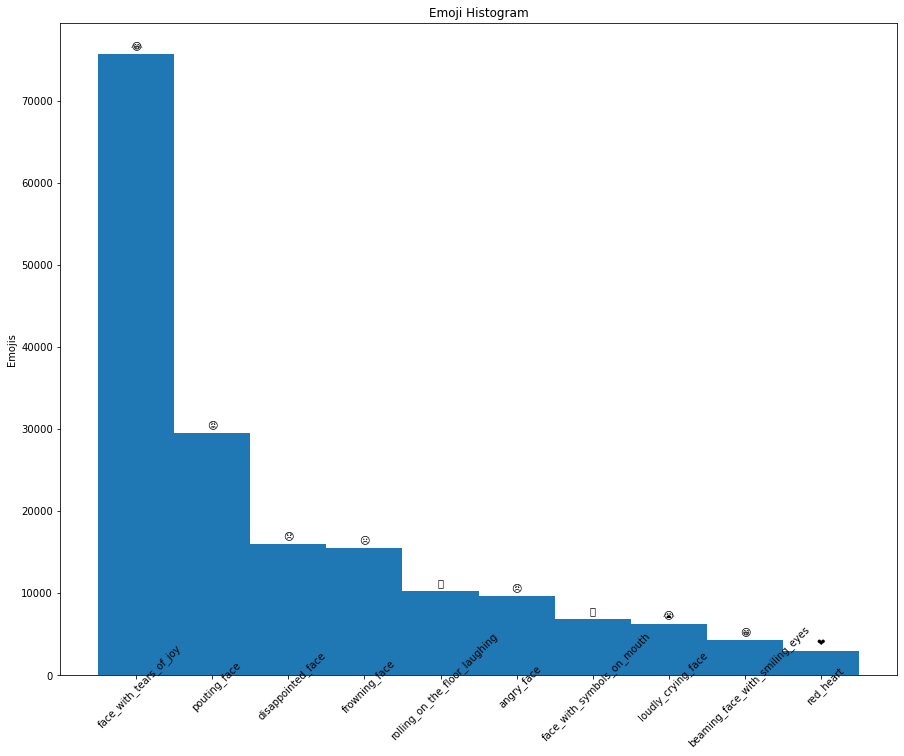

In [18]:
indexes = np.arange(len(labels))
width = 1

fig, ax = plt.subplots(figsize=[15,12])
rect = ax.bar(indexes, counts, width)

ax.set_ylabel('Emojis')
ax.set_title('Emoji Histogram')
ax.set_xticks(indexes,)
ax.set_xticklabels(labels, rotation=45, rotation_mode="anchor")

autolabel(rect,emoji_labels)

From the histogram, we can see that the crying laughing face is by far the most common emoji, followed by the pouting and disappointed face emojis. Although these might be indicative of a certain class, it is important to keep in mind that users may use certain emojis to express different things (i.e. sarcasm).